In [25]:
import struct
import time
from scipy.sparse import coo_matrix, csc_matrix
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
import networkx as nx

In [26]:
def read_trans_matrix(handle):
    matrix1d = []
    rows = struct.unpack('i', handle.read(4))[0]
    matrix1d.append(rows)
    for repeat in range(rows):
        rowlen = struct.unpack('i', handle.read(4))[0]
        matrix1d.append(rowlen)
        for fields in range(rowlen):
            matrix1d.append(struct.unpack('i', handle.read(4))[0])
            matrix1d.append(struct.unpack('f', handle.read(4))[0])
    return matrix1d


def read_uint_vector(handle):
    vectorlength = struct.unpack('i', handle.read(4))[0]
    print("Vector length: %i" % vectorlength)
    vector = []
    for i in range(vectorlength):
        vector.append(struct.unpack('i', handle.read(4))[0])
    return vector

def read_scalar_vector(handle):
    vectorlength = struct.unpack('i', handle.read(4))[0]
    print("Vector length: %i" % vectorlength)
    vector = []
    for i in range(vectorlength):
        vector.append(struct.unpack('f', handle.read(4))[0])
    return vector

def read_HSNE_binary(filename):
    with open(filename, 'rb') as handle:
        majorversion = struct.unpack('f', handle.read(4))[0]
        minorversion = struct.unpack('f', handle.read(4))[0]
        numscales = int(struct.unpack('f', handle.read(4))[0])
        scalesize = int(struct.unpack('f', handle.read(4))[0])
        print("Number of scales %i" % numscales )
        hierarchy = HSNE(numscales)
        print("Start reading first scale")
        tmatrix = read_trans_matrix(handle)
        tmatrix = hdi_to_sparse(tmatrix)
        print("Done reading first scale\n\n")
        hierarchy[0] = TopScale(num_scales=numscales, tmatrix=tmatrix)
        for i in range(1, numscales):
            subscale = build_subscale(handle, i, numscales)
            hierarchy[i] = subscale
        return hierarchy
    

def build_subscale(handle, i , numscales):
        print("Next scale: %i" % i)
        scalesize = int(struct.unpack('f', handle.read(4))[0])
        print("Scale size: %i" % scalesize)
        print("Reading transmatrix")
        tmatrix = hdi_to_sparse(read_trans_matrix(handle))
        subscale = SubScale(i, numscales, tmatrix)
        print("Reading landmarks of scale to original data")
        subscale.set_lm_to_original(read_uint_vector(handle))
        print("Landmarks to previous scale")
        subscale.set_lm_to_previous(read_uint_vector(handle))
        print("Landmark weights")
        subscale.set_lm_weights(read_scalar_vector(handle))
        print("Previous scale to current scale")
        subscale.set_previous_to_current(read_uint_vector(handle))
        print("AOI")
        # AOI matrix has many trailing 0's due to being shape (current scale size, next scale size)
        # Where a coo matrix is always shape (current scale size, current scale size)
        # TO DO FIX AOI SHAPE          
        subscale.set_area_of_influence(hdi_to_sparse(read_trans_matrix(handle)))
        print()
        return subscale

        
def hdi_to_sparse(hdidata):
    '''convert 1d array to scipy coordinate format sparse matrix
    data expected to be structured as:
    int number of rows 
        int number of fields in current row
            int column number of current field
            float value of current field
    in: 1d array
    out: scipy sparse matrix'''
    hdidata = hdidata[::-1]
    tt = time.time()
    columns = []
    rows = []
    edgeweights = []
    shape = int(hdidata.pop())
    for rownum in range(shape):
        for field in range(int(hdidata.pop())):
            rows.append(rownum)
            columns.append(hdidata.pop())
            edgeweights.append(hdidata.pop())
    print(time.time() - tt)
    return coo_matrix((edgeweights, (rows, columns)), shape=(shape, shape))


In [27]:
class HSNE():
    def __init__(self, num_scales):
        self.num_scales = num_scales
        self.scales = [i for i in range(num_scales)]
        self.index = -1
        
    def __str__(self):
        return "HSNE hierarchy with %i scales" % self.num_scales
    
    def __getitem__(self, index):
        return self.scales[index]
    
    def __setitem__(self, index, value):
        self.scales[index] = value

    def __iter__(self):
        return self
    
    def __next__(self):
        if self.index == self.num_scales - 1:
            self.index = -1
            raise StopIteration
        self.index += 1
        return self.scales[self.index]
    
    def get_topscale(self):
        return self.scales[0]
    

In [28]:
class TopScale(HSNE):
    def __init__(self, num_scales, tmatrix=None):
        self.tmatrix = tmatrix
        self.size = tmatrix.shape[0]
        self.datapoints = [idx for idx in range(self.size)]
        self.scalenum = 0
        self.num_scales = num_scales
        
    
    def __str__(self):
        return "HSNE top scale with %i datapoints" % self.size


In [29]:
class SubScale():
    def __init__(self,scalenum, num_scales, tmatrix):
        self.tmatrix = tmatrix
        self.size = tmatrix.shape[0]
        self.datapoints = [idx for idx in range(self.size)]
        self.scalenum = scalenum
        self.num_scales = num_scales
        self.lm_to_original = None
        self.lm_to_previous = None
        self.lm_weights = None
        self.previous_to_current = None
        self.area_of_influence = None
        
    def __str__(self):
        return "HSNE subscale %i with %i datapoints" % (self.scalenum, self.size)
    
    def set_lm_to_original(self, data):
        self.lm_to_original = data
    
    def set_lm_to_previous(self, data):
        self.lm_to_previous = data
    
    def set_lm_weights(self, data):
        self.lms_weights = data
    
    def set_previous_to_current(self, data):
        self.previous_to_current = data
    
    def set_area_of_influence(self, data):
        self.area_of_influence = csc_matrix(data)[:, :self.size]

In [30]:
hsne = read_HSNE_binary('./HSNE_files/mnis_aoi.bin')

Number of scales 3
Start reading first scale
0.032299041748046875
Done reading first scale


Next scale: 1
Scale size: 236
Reading transmatrix
0.019017934799194336
Reading landmarks of scale to original data
Vector length: 236
Landmarks to previous scale
Vector length: 236
Landmark weights
Vector length: 236
Previous scale to current scale
Vector length: 1000
AOI
0.05577397346496582

Next scale: 2
Scale size: 29
Reading transmatrix
0.0019636154174804688
Reading landmarks of scale to original data
Vector length: 29
Landmarks to previous scale
Vector length: 29
Landmark weights
Vector length: 29
Previous scale to current scale
Vector length: 236
AOI
0.007797956466674805



In [31]:
for scale in hsne:
    print(scale)

HSNE top scale with 1000 datapoints
HSNE subscale 1 with 236 datapoints
HSNE subscale 2 with 29 datapoints


In [46]:
test = hsne[1]
test.area_of_influence.shape

(1000, 236)

/home/paul/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


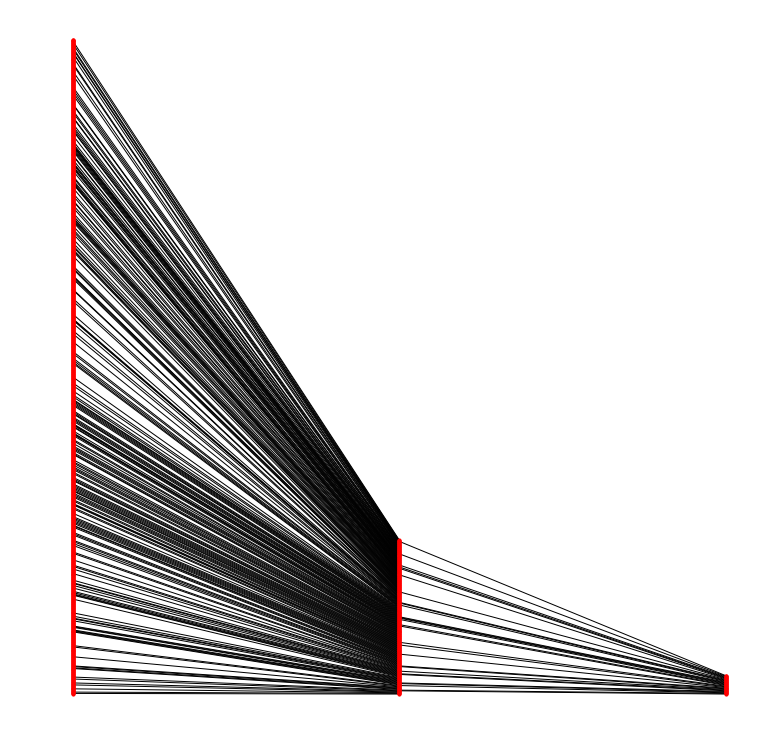

In [34]:
G = nx.Graph()
positions = {}
for scale in hsne[::-1]:
    for node in scale.datapoints:
        G.add_node(str(scale.scalenum) + "_" + str(node))
        positions[str(scale.scalenum) + "_" + str(node)] = [scale.scalenum, node]
        
for scale in hsne[1:][::-1]:
    for num, node in enumerate(scale.lm_to_previous):
        G.add_edge(str(scale.scalenum) + "_" + str(num), str(scale.scalenum -1) + "_" + str(node))
nx.draw(G, pos=positions, node_size=10)

/home/paul/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


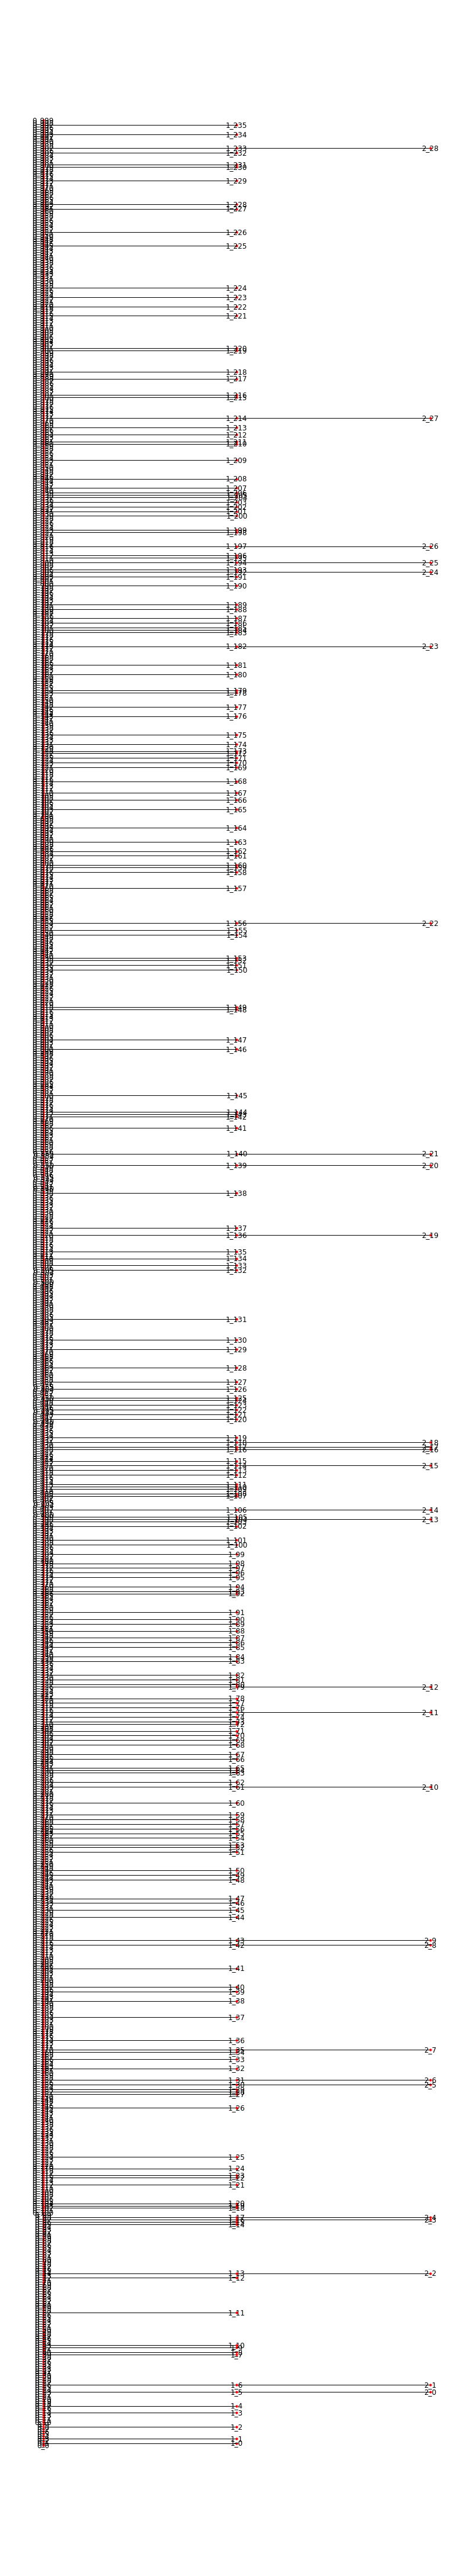

In [35]:
rcParams['figure.figsize'] = 10, 60
G = nx.Graph()
positions = {}
for scale in hsne[::-1]:
    for node in range(scale.size):
        G.add_node(str(scale.scalenum) + "_" + str(node))
        if isinstance(scale, SubScale):
            positions[str(scale.scalenum) + "_" + str(node)] = [scale.scalenum, scale.lm_to_original[node]]
        else:
            positions[str(scale.scalenum) + "_" + str(node)] = [scale.scalenum, node]
for scale in hsne[1:][::-1]:
    for num, node in enumerate(scale.lm_to_previous):
        G.add_edge(str(scale.scalenum) + "_" + str(num), str(scale.scalenum -1) + "_" + str(node))
nx.draw(G, pos=positions, node_size=10, with_labels=True)